In [14]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from functools import partial
import randcbpside
import randcbpside2
import games 
import random
import math
import pandas as pd


class Evaluation_contextual:

    def __init__(self, horizon ):

        self.horizon = horizon
        

    def get_contexts(self, context_generator):
        # outcomes = np.random.choice( 2 , p= self.distribution, size= self.horizon) 
        contexts =  [ context_generator.get_context(t)[0] for t in range(self.horizon) ]
        regions = [ context_generator.get_context(t)[1] for t in range(self.horizon) ]
        return contexts, regions

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, job):#jobid
        context_generator, seed = job
        np.random.seed(seed)
        alg.reset()

        self.contexts, self.regions = self.get_contexts( context_generator )
        cumRegret =  np.zeros(self.horizon, dtype =float)
        actions = np.zeros(self.horizon, dtype =float)
        alg.reset()

        for t in range(self.horizon):
            # print(t)

            context = self.contexts[t]
            region = self.regions[t]
            distribution = context_generator.get_distribution(context)
            if region == 1:
                outcome = np.random.choice( 2 , p = [0.5,0.5] )       
            else:
                outcome = np.random.choice( 2 , p = distribution )

            action = alg.get_action(t, context)
            
            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, t, context )

            i_star = np.argmin(  [ game.LossMatrix[i,...] @ np.array( distribution ) for i in [0,1,2] ]  )
            loss_diff = game.LossMatrix[action,...] - game.LossMatrix[i_star,...]
            val = loss_diff @ np.array( distribution )

            # regret = game.LossMatrix[action, outcome] - np.min( game.LossMatrix[...,outcome] )

            cumRegret[t] =  val
            actions[t] = action

        return  np.cumsum( cumRegret ) #, actions
    
def generate_nonuniform_vectors(size):
    while True:
        alpha = [ np.random.randint(2,10) ] * size # shape parameter
        sample = np.random.dirichlet(alpha, size=1)
        if sample[0][0] < 0.1:
            return sample[0]

class XYZContexts:
    def __init__(self, w,):
        self.d = len(w) #number of features
        self.w = w
        self.imbalance = generate_nonuniform_vectors(4)
        # print(self.imbalance)
    def get_context(self,t):

        c = np.random.choice([0,1,2,3],p=self.imbalance  ) #[1,0,0]  #generate_nonuniform_vectors()
        while True:
            if c == 0:
                context = np.random.uniform(0, 1,  self.d )
                return np.array(context).reshape(self.d,1),c
            elif c == 1:
                center = (0.1, 0.1, 0.1)
                radius = 0.025
                x = np.random.uniform(center[0]-radius, center[0]+radius)
                y = np.random.uniform(center[1]-radius, center[1]+radius)
                z = np.random.uniform(center[2]-radius, center[2]+radius)
                distance = math.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2)
                if distance <= radius:
                    context = [x,y,z]
                    return np.array(context).reshape(self.d,1),c
            elif c == 2:
                center = (0.6, 0.6, 0.9)
                radius = 0.025
                x = np.random.uniform(center[0]-radius, center[0]+radius)
                y = np.random.uniform(center[1]-radius, center[1]+radius)
                z = np.random.uniform(center[2]-radius, center[2]+radius)
                distance = math.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2)
                if distance <= radius:
                    context = [x,y,z]
                    return np.array(context).reshape(self.d,1),c
            elif c == 3:
                center = (0.3, 0.2, 0.65)
                radius = 0.1
                x = np.random.uniform(center[0]-radius, center[0]+radius)
                y = np.random.uniform(center[1]-radius, center[1]+radius)
                z = np.random.uniform(center[2]-radius, center[2]+radius)
                distance = math.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2)
                if distance <= radius:
                    context = [x,y,z]
                    return np.array(context).reshape(self.d,1),c


    def get_distribution(self,cont):
        val = self.w @ cont
        return [ val[0], 1-val[0] ]

class LinearContexts:
    def __init__(self, w, b, d, margin):
        self.d = d #number of features
        self.margin = margin #np.random.uniform(0,0.5) # decision boundary
        self.b = b #np.random.uniform(-1,1)
        self.w = w
        self.type = 'linear'
        self.d_context = 2

    # def get_context(self,t):
    #     c= np.random.choice([0,1,2],p=[0.2,0.4,0.4]  ) #[1,0,0] 
    #     if c == 0:
    #         context = np.random.uniform(0, 0.5,  self.d )
    #     elif c == 1:
    #         context = [0.5,0.5]
    #     elif c == 2:
    #         context = [0,0]

    #     return np.array(context).reshape(self.d,1)
    
    def get_context(self,t):
        c= np.random.choice([0,1,2,3],p=generate_nonuniform_vectors(4)  ) #[1,0,0]  #generate_nonuniform_vectors()
        while True:
            context = np.random.uniform(0, 0.5,  self.d )
            if context[0]<0.25 and context[1]<0.25 and c == 0:
                return np.array(context).reshape(self.d,1)
            elif context[0]<0.25 and context[1]>=0.25 and c == 1:
                return np.array(context).reshape(self.d,1)
            elif context[0]>=0.25 and context[1]<0.25 and c == 2:
                return np.array(context).reshape(self.d,1)
            elif context[0]>=0.25 and context[1]>=0.25 and c == 3:
                return np.array(context).reshape(self.d,1)


    def get_distribution(self,cont):
        val = self.w @ cont
        return [ val[0], 1-val[0] ]
    

def evaluate_parallel(n_folds, horizon, algo, gam ):
    print("nbCores:", 10, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = 10) 
    
    np.random.seed(1)
    # w = np.array([1,1])
    # b = 0
    # d = 2
    # margin = 0.5
    task = Evaluation_contextual(horizon)
    jobs = []
    for _ in range(n_folds):
        w = w = np.array([0.1,0.1,0.8])#generate_nonuniform_vectors(3) 
        # jobs.append( [ LinearContexts(w, b, d, margin) , _  ] )
        jobs.append( [ XYZContexts(w ) , _  ] )

    partial_func = partial( task.eval_policy_once,  algo, gam )

    return  np.asarray(  pool.map( partial_func, jobs ) ) 

In [15]:
dim = 3
horizon = 2500
nfolds = 10
game = games.label_efficient()
alg1 = randcbpside.RandCPBside( game, dim, 1.01, 0.05, 1, 10, 10e-7)
res1 = evaluate_parallel(nfolds, horizon, alg1, game )

alg2 = randcbpside2.RandCPBside(game, dim, 1.01, 0.05, 1, 10, 10e-7)
res2 = evaluate_parallel(nfolds, horizon, alg2, game )

nbCores: 10 nbFolds: 10 Horizon: 2500
nbCores: 10 nbFolds: 10 Horizon: 2500


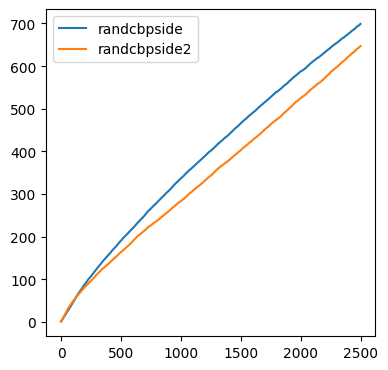

In [16]:
plt.figure(figsize=(4.25, 4.25))
plt.plot( range(horizon), np.mean(res1,0), label = 'randcbpside' )
plt.plot( range(horizon), np.mean(res2,0), label = 'randcbpside2' )
plt.legend()
# plt.savefig('./uniform_contexts.png', bbox_inches='tight', dpi=300)

In [ ]:



horizon = 1000

game = games.label_efficient()
w = np.array([1,1])
b = 0
d = 2
margin = 0.5


context_generator  = LinearContexts(w, b, d, margin)
eval = Evaluation_contextual(horizon, context_generator)


reg1,act1 = eval.eval_policy_once( alg1, game)

alg2 = randcbpside2.RandCPBside(game, dim, 1.01, 0.05, 1, 10, 10e-7)
reg2,act2 = eval.eval_policy_once( alg2, game)

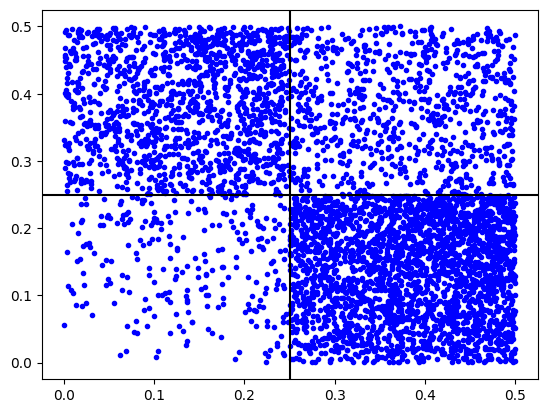

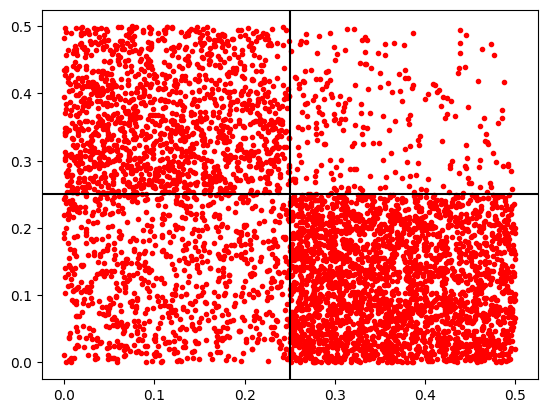

In [54]:
import numpy as np
import matplotlib.pyplot as plt

w = np.array([1,1])
b = 0
d = 2
margin = 0.5

lin = LinearContexts(w, b, d, margin)

contexts_x = []
contexts_y = []
outcomes = []
for _ in range(10000):
    cont = lin.get_context2(10)
    distribution = lin.get_distribution(cont)
    outcome = np.random.choice( 2 , p = distribution ) 
    outcomes.append(outcome)
    contexts_x.append(cont[0][0])
    contexts_y.append(cont[1][0])

plt.plot([ i if j ==0 else np.nan for i,j in zip(contexts_x,outcomes)] ,[ i if j ==0 else np.nan for i,j in zip(contexts_y,outcomes)] ,'.',color = 'blue')
plt.axvline(x=0.25, color='black')
plt.axhline(y=0.25, color='black')
plt.savefig('./outcomes0_nonuniform.png', bbox_inches='tight', dpi=300)
plt.show()

plt.plot([ i if j ==1 else np.nan for i,j in zip(contexts_x,outcomes)] ,[ i if j ==1 else np.nan for i,j in zip(contexts_y,outcomes)] ,'.' ,color = 'red')
plt.axvline(x=0.25, color='black')
plt.axhline(y=0.25, color='black')
plt.savefig('./outcomes1_nonuniform.png', bbox_inches='tight', dpi=300)
plt.show()


# contexts_x = []
# contexts_y = []
# for _ in range(500):
#     cont = lin.get_context(1,10)
#     contexts_x.append(cont[0][0])
#     contexts_y.append(cont[1][0])

# plt.plot(contexts_x,contexts_y,'.')

In [50]:






w = np.array([0,0,1])
gen = XYZContexts(w)

df = pd.DataFrame()

for _ in range(1000):
    vec = gen.get_context(10)
    p = w @ vec
    df_temp = pd.DataFrame({'x': [vec[0][0]], 'y':[vec[1][0] ], 'z': [vec[2][0] ], 'p': [ p[0] ]})
    df = pd.concat([df, df_temp])



In [51]:
import plotly.express as px
# df = px.data.iris()
fig = px.scatter_3d(df, x='x', y='y', z='z', color='p', 
                    color_continuous_scale='Viridis', range_color=[0, 1],  opacity=0.7)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.update_scenes(xaxis=dict(range=[0, 1]), yaxis=dict(range=[0, 1]), zaxis=dict(range=[0, 1]))
fig.update_layout(scene=dict(xaxis=dict(tickmode='linear', tick0=0, dtick=0.1),
                             yaxis=dict(tickmode='linear', tick0=0, dtick=0.1),
                             zaxis=dict(tickmode='linear', tick0=0, dtick=0.1)))

fig.update_layout(scene=dict(xaxis=dict(range=[1, 0], zeroline=False),
                             yaxis=dict(range=[1, 0], zeroline=False),
                             zaxis=dict(range=[0, 1], zeroline=False)))

fig.update_traces(marker=dict(size=3))

# Show the plot
